<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood_Hessians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     \ 10.9MB 12.1MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0516 19:12:42.121882 139644566660992 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:

from tensorflow.contrib.opt import ScipyOptimizerInterface
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [156]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
grad_opt      = tf.train.GradientDescentOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth


### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])

opt_BFGS             = ScipyOptimizerInterface(loss_MAP,method='BFGS')
opt_trust            = ScipyOptimizerInterface(loss_MAP,method='trust-exact')
opt_CG               = ScipyOptimizerInterface(loss_MAP,method='CG')

##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

num_chains =20

def unnormalized_log_prob(x):
  
  fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

  # option to use uncorrected latent space
  gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

  likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

  likeli_log_prob_x  = likeli_x.log_prob(x_corr)

  prior_x            = prior.log_prob(x)

  posterior_x        = prior_x+likeli_log_prob_x

  return posterior_x


#### ----- this is an hmc sampler------------#

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)



ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# Initialize the HMC transition kernel.
num_results      = int(2e4)
num_burnin_steps = int(2e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)
#### ----- this is an hmc sampler------------#

#### ----- this is a a Random Walk Metropolis Hastings------------#

# Initial state of the chain
init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# Run Random Walk Metropolis with normal proposal for `num_results`
# iterations for `num_chains` independent chains:
mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_log_prob,
        seed=54,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
    num_burnin_steps=num_burnin_steps,
    num_steps_between_results=10,  # Thinning.
    parallel_iterations=1)


# # # construct a GMM approximation from different minima
num_comp = 3

ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tf.Variable(tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus))

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = tf.stop_gradient(w_gmm.assign(w_est))
update_b      = tf.stop_gradient(mu_gmm.assign(mu_est))
update_c      = tf.stop_gradient(sigma_gmmt.assign(sigma_est))
update_d      = tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_gmm, transform=softplus_inverse)))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  =tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

#### optimize on GMM using EL20

gmm_sample    = tf.identity(gmm.sample())
fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2,data_dim,n_channels])

likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_corr))

likeli_log_prob_z = likeli_z.log_prob(x_corr)

prior_z       = prior.log_prob(gmm_sample)

posterior_z   = -(prior_z+likeli_log_prob_z)

posterior_gmm = -gmm.log_prob(gmm_sample)

grad_gmm      = tf.gather(tf.gradients(posterior_gmm,gmm_sample),0)

grad_post     = tf.gather(tf.gradients(posterior_z,gmm_sample),0)

gradgrad_gmm  = tf.reduce_sum(tf.gather(tf.hessians(grad_gmm,gmm_sample),0),axis=2)

gradgrad_post = tf.reduce_sum(tf.gather(tf.hessians(grad_post,gmm_sample),0),axis=2)

el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z))+tf.reduce_mean(tf.square(grad_post-grad_gmm))+tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

opt_op_el2o   = optimizer.minimize(el2o,var_list=[w_gmm, mu_gmm, sigma_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:41.836858 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:41.892884 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:41.982157 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:42.626605 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:43.051278 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:43.141294 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:44.252125 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:44.358397 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:44.768316 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:44.875683 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:45.370827 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:45.490000 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:46.637783 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:46.778352 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:47.272291 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:47.424679 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:47.794704 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:47.955520 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:48.061303 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:54.273448 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:54.478946 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:56.246713 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:56.484009 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:56.670319 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:59.014882 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:59.298971 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:57:59.510523 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:01.160456 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:01.441455 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:01.680153 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:03.988706 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:04.302270 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:04.545879 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:05.568381 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:05.880444 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:06.505289 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:06.834450 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 23:58:07.108790 139644566660992 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


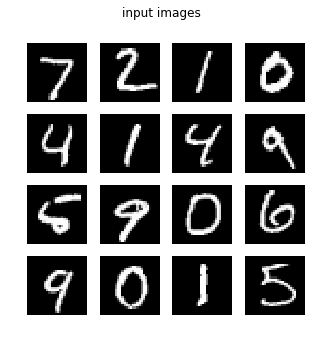

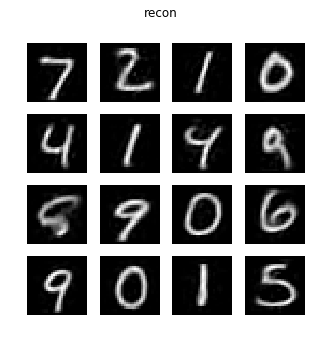

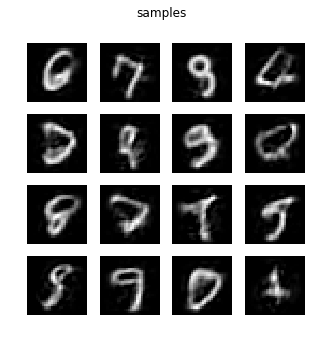

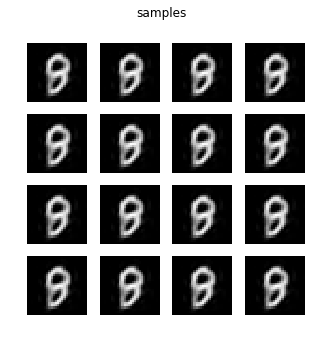

In [13]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:05:08.029361 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


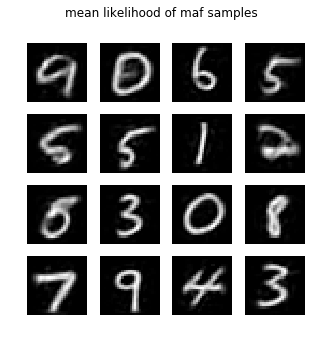

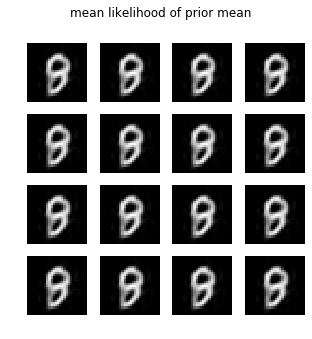

In [29]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


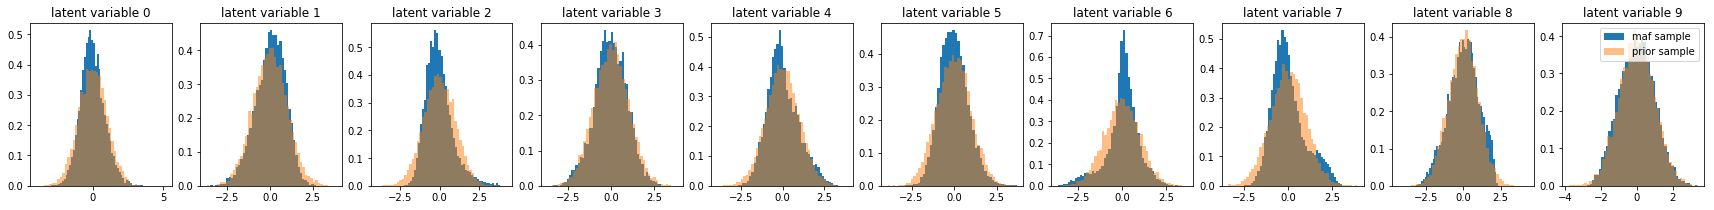

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

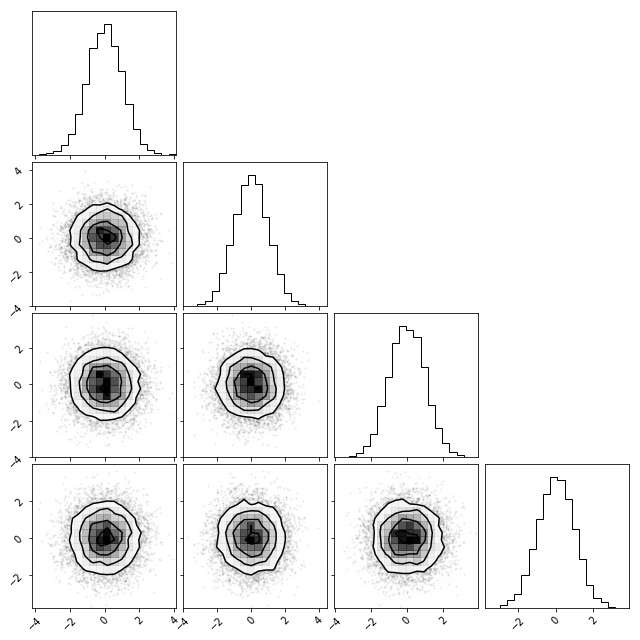

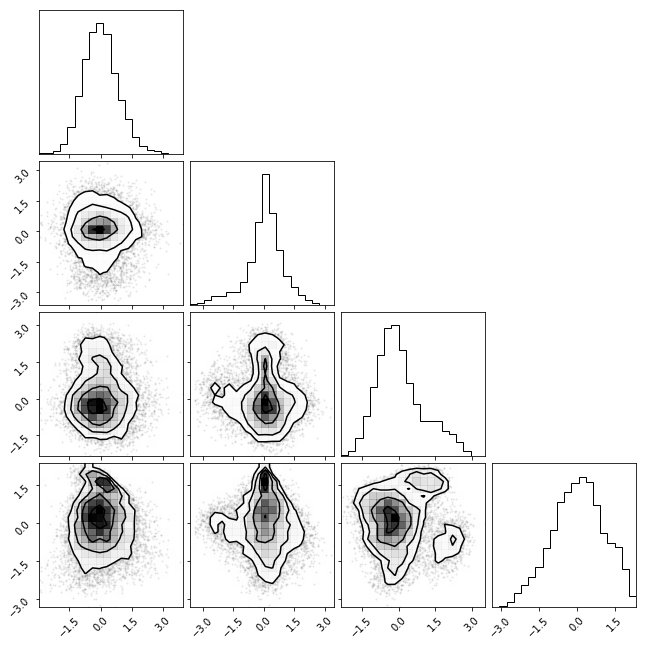

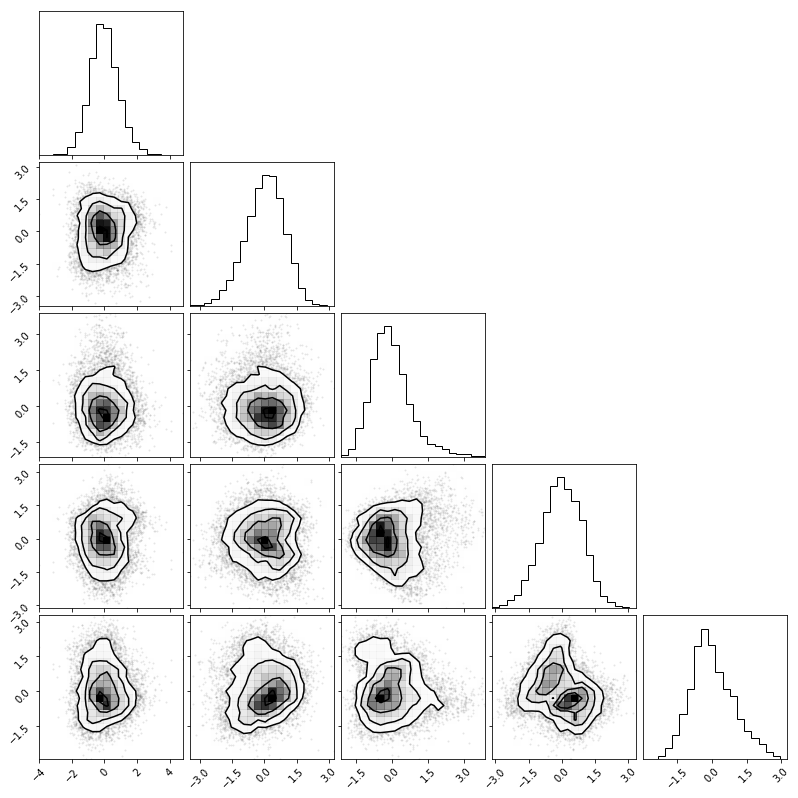

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

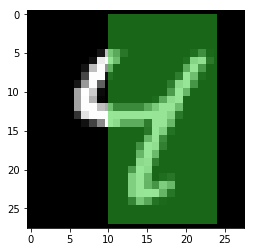

In [125]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 10
maxx = 24
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [132]:
lrate=1e-3
for ii in range(16000):
  if ii >8000:
    lrate=1e-4
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

2633.6372
2629.8215
2628.2727
2628.0662
2629.6973
2633.3845
2642.1213
2630.141
2631.8916
2630.8108
2634.5547
2640.4805
2637.6824
2632.392
2643.9277
2631.041


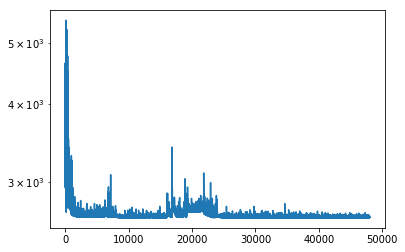

In [133]:
plt.plot(posterior_loss)
yscale('log')

In [134]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 1.5420538  -0.42289233 -0.91307974  0.8211902   0.13227974  0.9008279
   0.4744373  -3.235739    0.2653391   1.0798557 ]] [-19.203896]


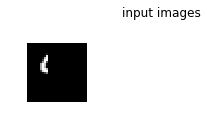

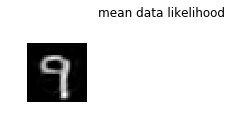

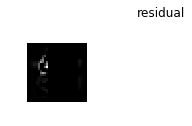

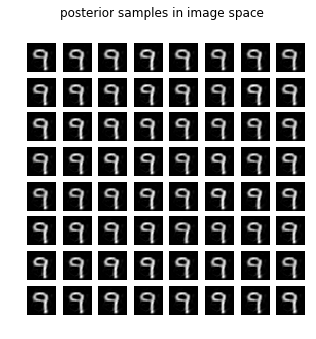

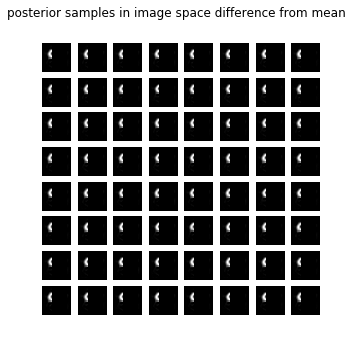

In [135]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('residual')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVImasked_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except: 
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [143]:
lrate=1e-3
for ii in range(8000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

2657.5825
2658.5762
2662.7537
2653.0906
2653.2043
2655.795
2658.9573
2664.285


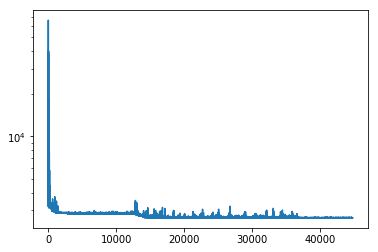

In [144]:
plt.plot(posterior_loss)
yscale('log')

In [145]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[-0.64900273 -1.0745004  -1.3077915   2.6800232   0.56117857  0.9857219
  -3.762606    0.17987494  2.7829196   2.9288723 ]] [-13.17554]


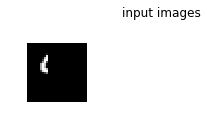

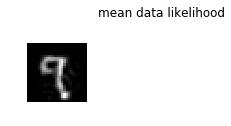

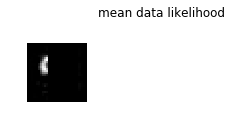

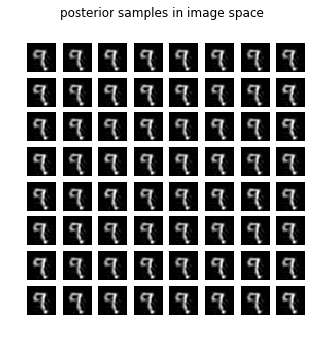

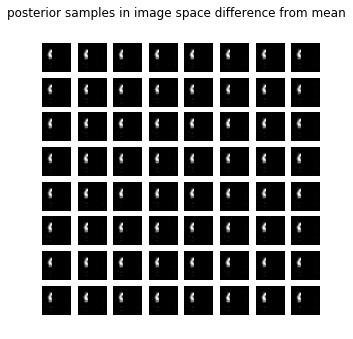

In [146]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samplesmasked_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
try:
  VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  
  pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

**find minima with nvp**

0
2985.1084
2626.5837
2628.8362
2626.8486
2633.2783
2631.9617
2626.9
2628.3623
2637.8333
2625.3655
2632.3135
2625.1372
2625.1384
2625.1836
2625.153
2625.1733
2625.159
2625.1353
2625.1438
2625.1465
switching to lr 0.001
2625.1648
2625.1243
2625.124
2625.1294
[[-4.8111105e+00  6.2388337e-01  2.4310081e+00  5.5262184e+00
   1.6040737e+01  2.0886026e+01  8.1385918e+01  1.9595834e+02
   5.5615295e+02  2.0112629e+04]]
1
2883.389
2617.4285
2617.6953
2615.346
2615.4722
2618.2236
2610.7283
2610.4343
2646.5684
2615.2786
2616.6565
2615.2622
2615.2603
2615.2656
2615.2603
2615.2578
2615.267
2615.2695
2615.285
2615.2937
switching to lr 0.001
2615.2656
2615.2603
2615.257
2615.2595
[[1.8119271e-01 1.1602910e+00 1.6910380e+00 4.2650094e+00 1.0280976e+01
  1.1289983e+01 9.7536537e+01 1.0420771e+03 3.6798306e+03 9.2137246e+03]]
2
3319.9912
2610.9036
2607.3938
2635.4585
2626.988
2626.79
2647.4177
2605.4578
2605.3545
2605.9578
2605.4468
2605.3022
2605.2896
2605.2854
2605.267
2605.2998
2605.3704
2605.3083
2

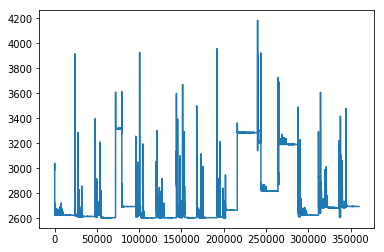

In [148]:
posterior_corr_loss = []
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(15):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
#   for jj in range(3):
#     opt_BFGS.minimize(sess,feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
#     ll=sess.run(loss_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
#     posterior_corr_loss.append(ll)
  lrate=1e-1
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]
plot(posterior_corr_loss,label='data_loss')

In [149]:
print(pos_def)

[1, 2, 7, 8, 14]


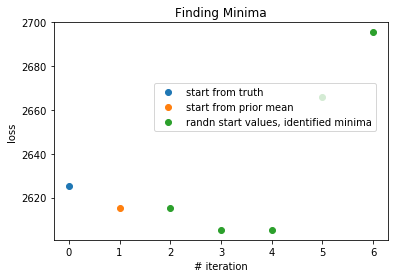

In [150]:
# print(pos_def)
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)
l_minima_pos_def   = l_minima[pos_def]
map_minima_pos_def = map_minima[pos_def]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(map_minima_pos_def))+2,l_minima_pos_def,ls='',marker='o', label='randn start values, identified minima')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend(loc=(0.3,0.5))
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d_nolbfgs.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima,l_minima_pos_def,map_minima_pos_def = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d_nolbfgs.pkl'%(minx,maxx),'rb'))
  #l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def],open(minima_path+'nvp_minima_xmin%d_xmax%d_nolbfgs.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [152]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.7205856  -1.2527179  -0.34172425  1.6792735   0.30119264
    0.9797948  -0.3276317  -2.3625302   0.79844385 -0.31930453]]]
[[-0.64900273 -1.0745004  -1.3077915   2.6800232   0.56117857  0.9857219
  -3.762606    0.17987494  2.7829196   2.9288723 ]]
[[ 1.5420538  -0.42289233 -0.91307974  0.8211902   0.13227974  0.9008279
   0.4744373  -3.235739    0.2653391   1.0798557 ]]


**Sample posterior of (un)corrupted data**

In [0]:
samples_mcmc, mcmc_stats_ = sess.run([mcmc_samples,mcmc_stats],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

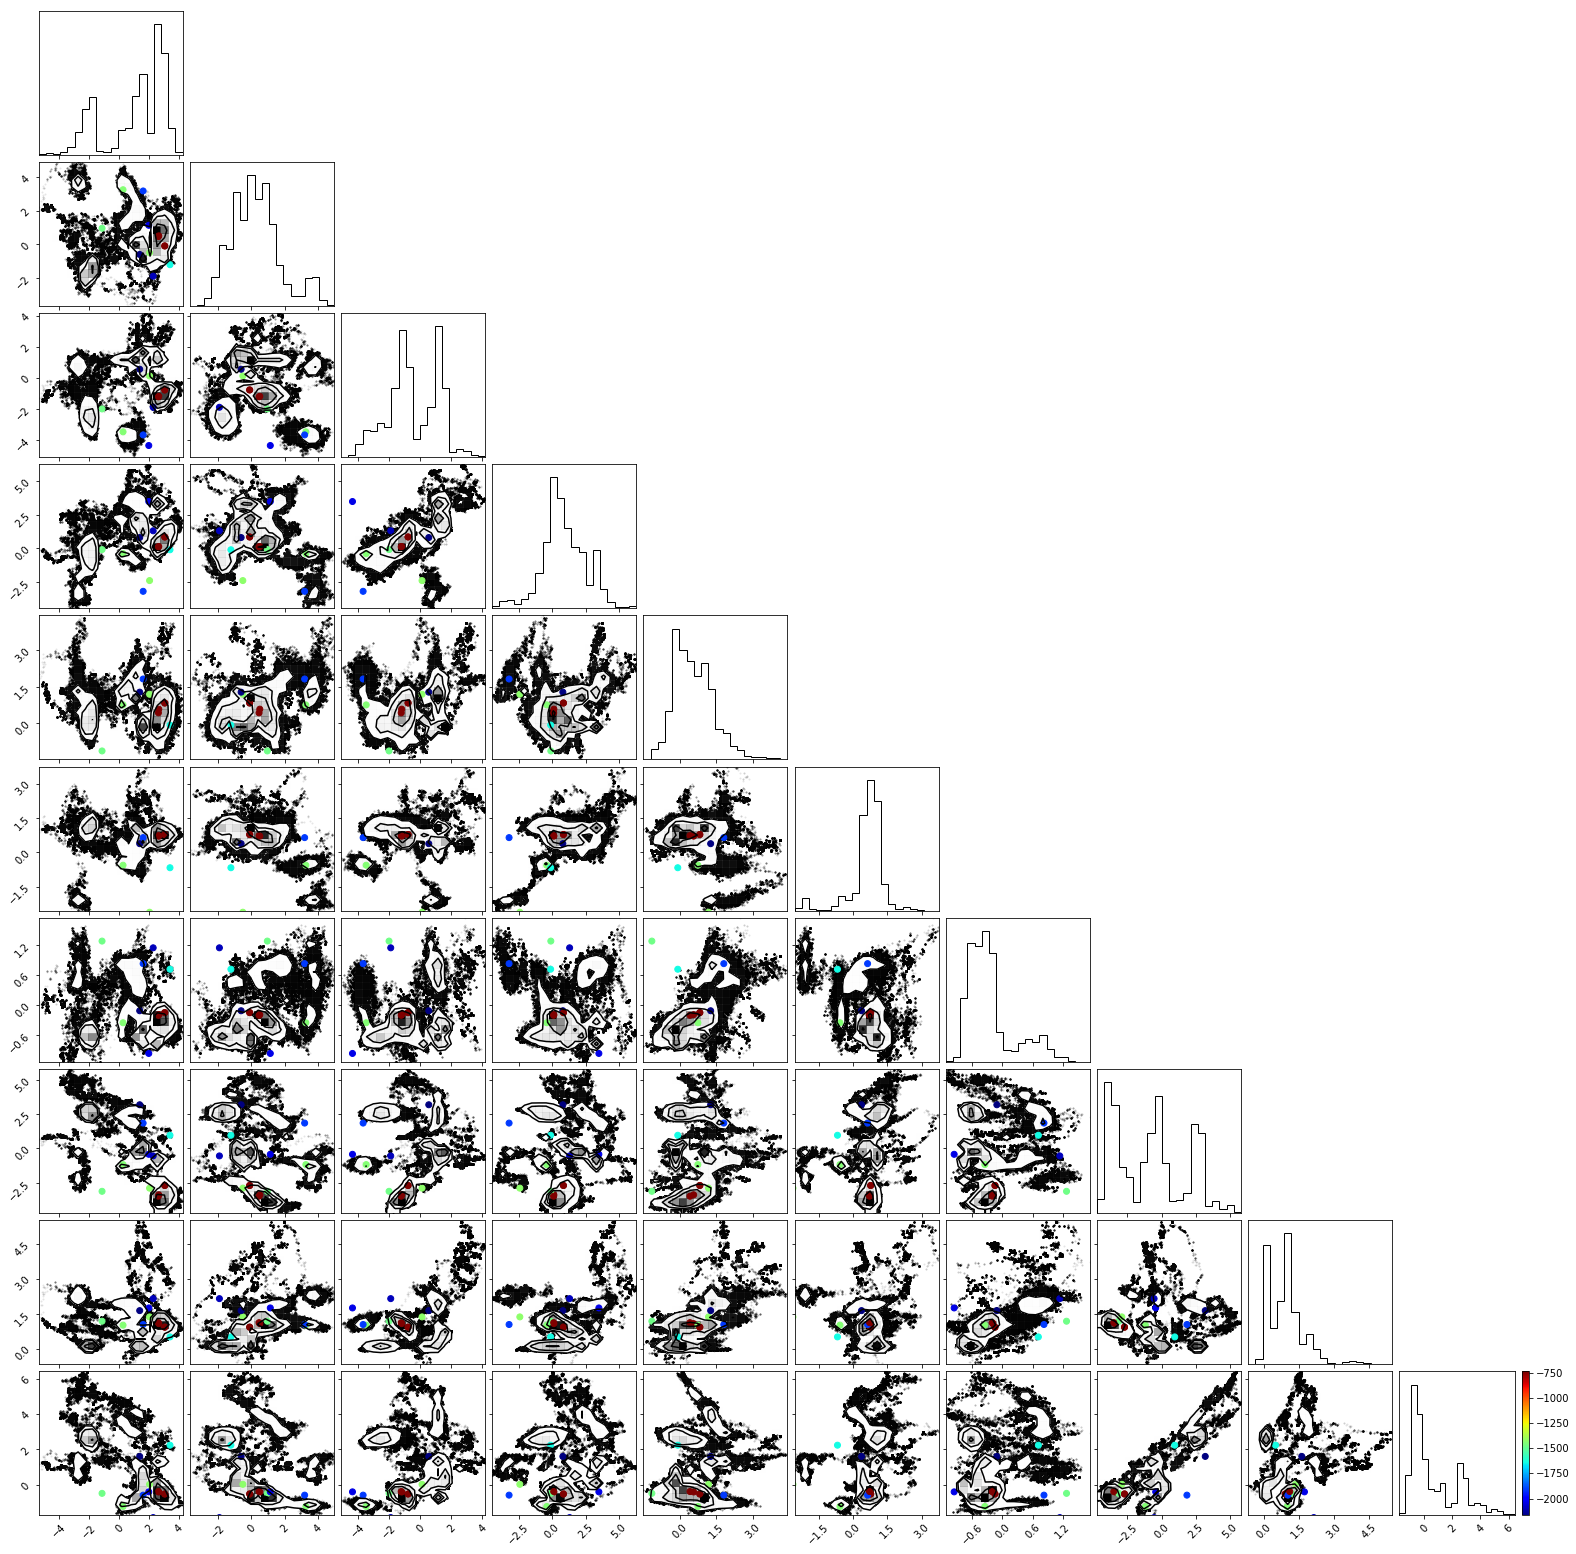

In [123]:
figure = corner.corner(np.reshape(samples_mcmc,[-1,hidden_size]))
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

In [96]:
samples_.shape
print(max(kernel_results_.accepted_results.target_log_prob.flatten()),-min(l_minima))

-987.4353 -734.68427


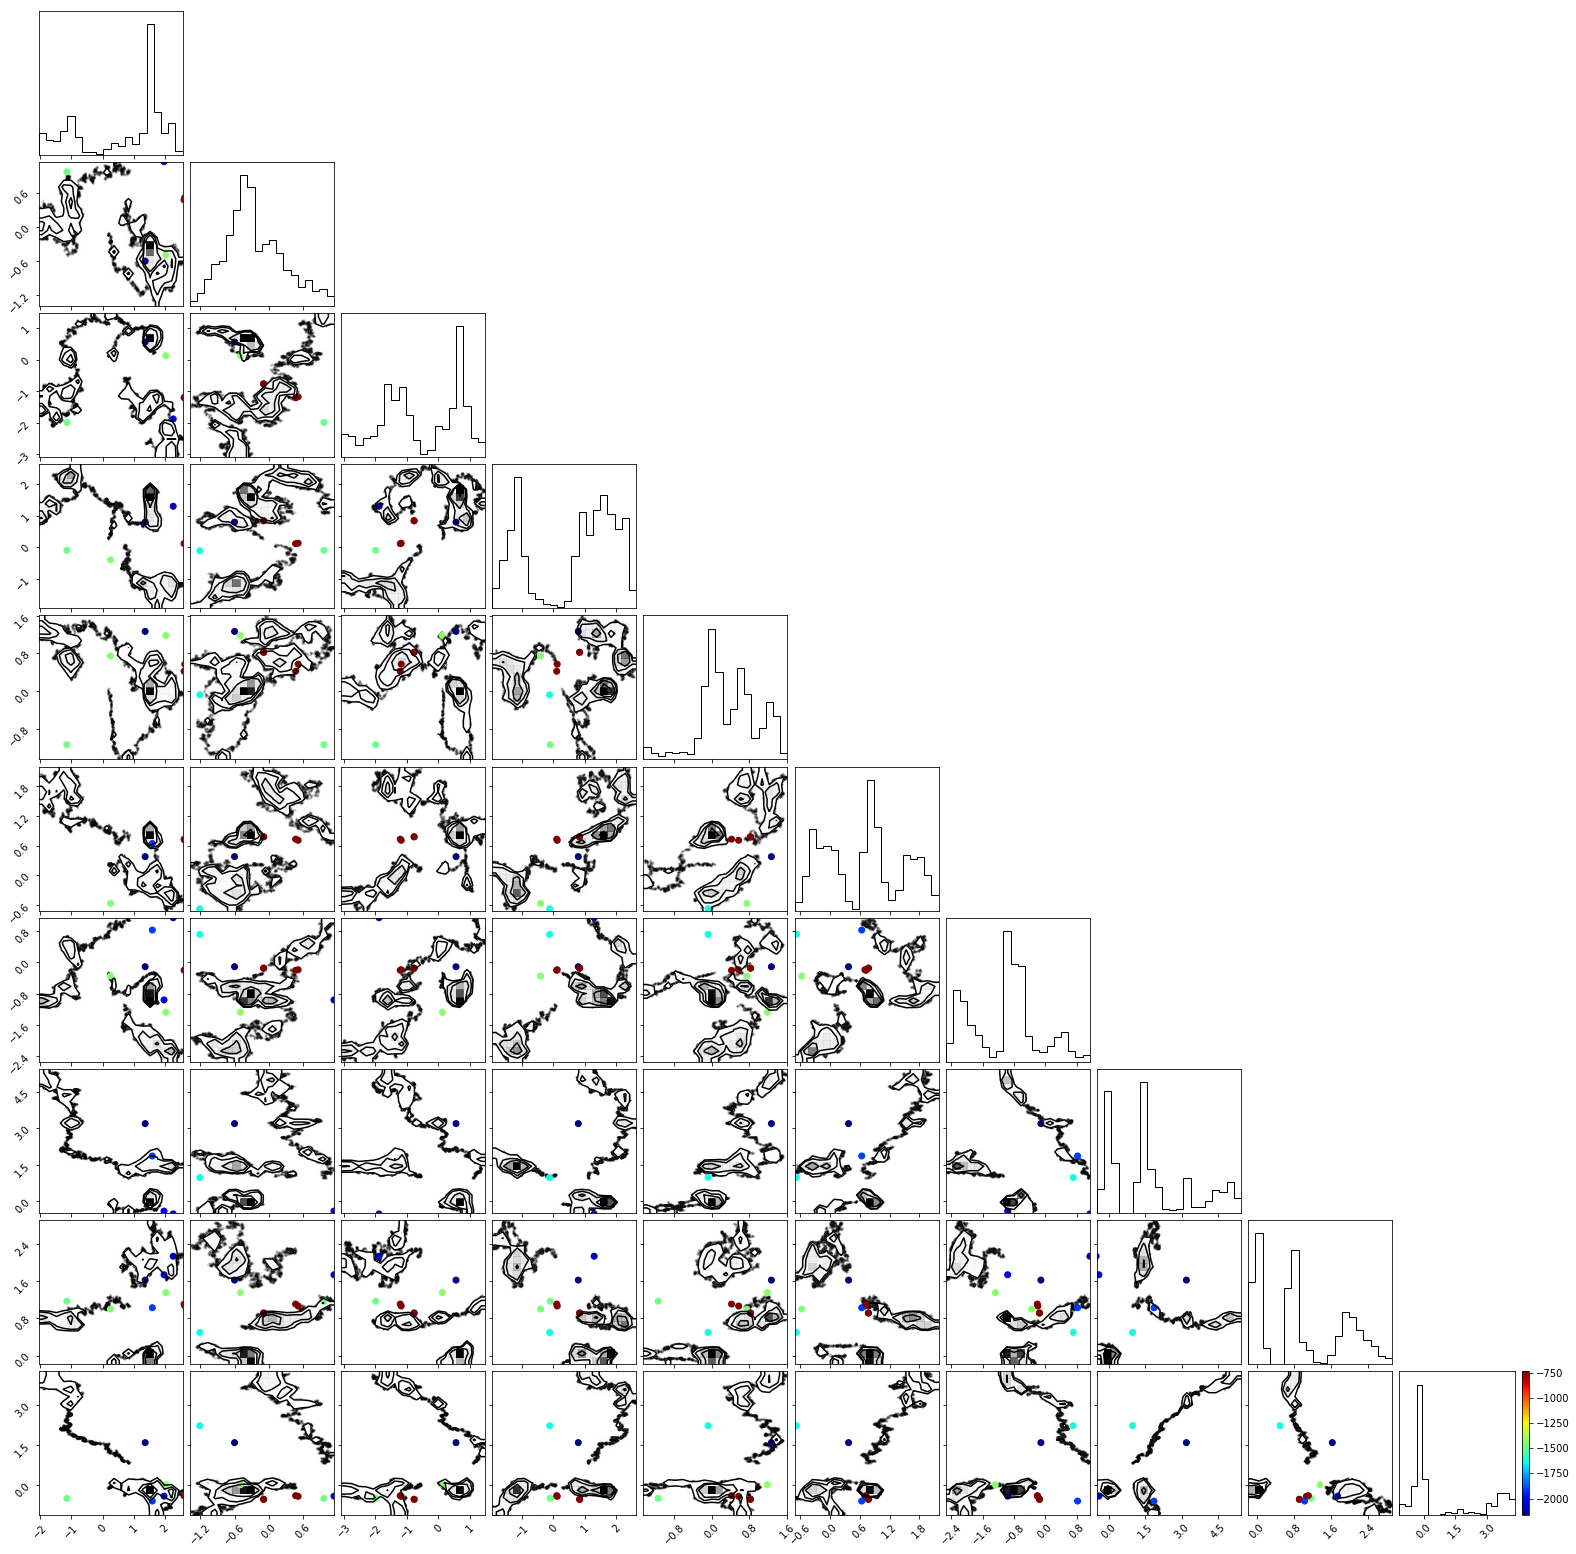

In [111]:
order = np.argsort(l_minima)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

mean:0.1693  stddev:0.9419  acceptance:0.6615


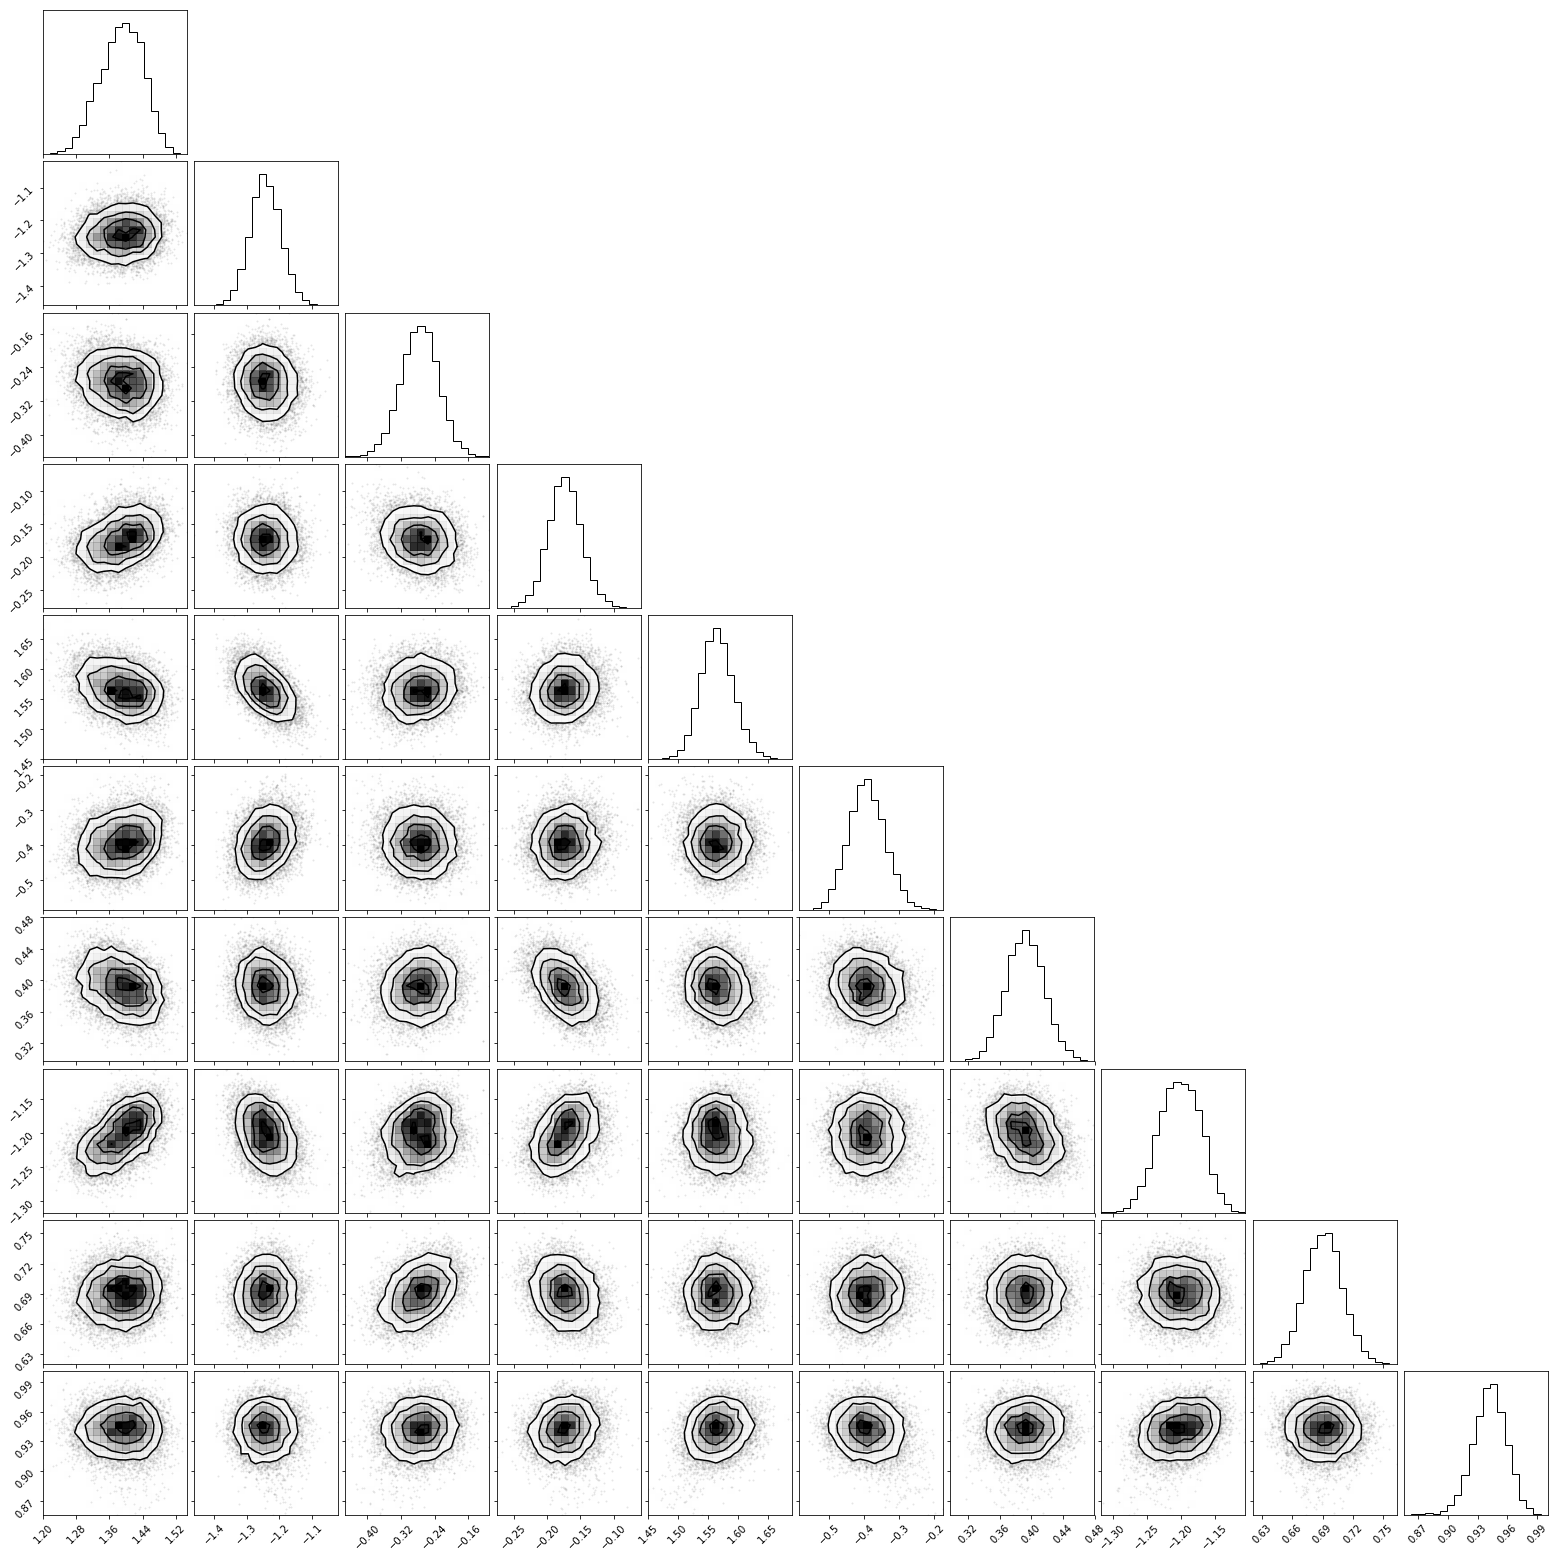

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

In [105]:
data.shape

(1, 784, 1)

**get covariances around minima**

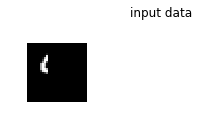

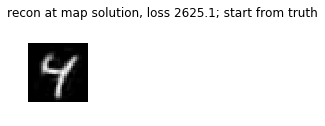

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


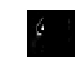

eigenvalues before and after inverse, approx hessian
[array([[9.9441332e-01, 9.9877244e-01, 9.9959040e-01, 9.9993688e-01,
        9.9999964e-01, 1.0000017e+00, 1.0000769e+00, 1.0002455e+00,
        1.0014379e+00, 1.3345094e+05]], dtype=float32), array([[7.49338982e-06, 9.99188961e-01, 9.99893802e-01, 9.99962820e-01,
        9.99999517e-01, 1.00000537e+00, 1.00003011e+00, 1.00051423e+00,
        1.00080474e+00, 1.00287037e+00]])]


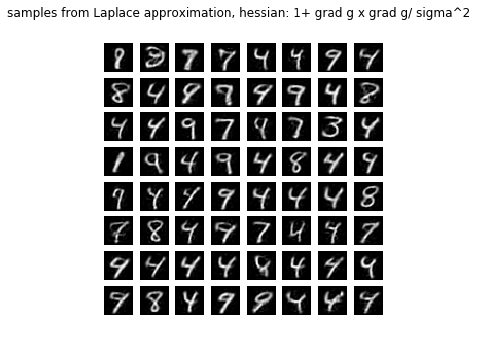

covariances
(1, 10, 10)


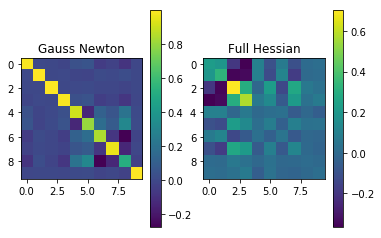

hessians
(1, 10, 10)


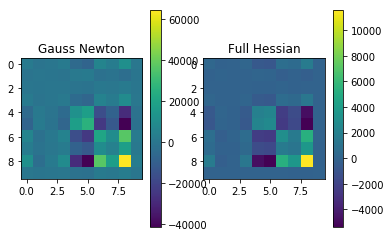

eigenvalues before and after inverse, full hessian
[array([[-4.8111105e+00,  6.2388337e-01,  2.4310081e+00,  5.5262184e+00,
         1.6040737e+01,  2.0886026e+01,  8.1385918e+01,  1.9595834e+02,
         5.5615295e+02,  2.0112629e+04]], dtype=float32), array([[-2.07881725e-01,  4.97200101e-05,  1.79806569e-03,
         5.10312788e-03,  1.22872632e-02,  4.78789026e-02,
         6.23422775e-02,  1.80952474e-01,  4.11364569e-01,
         1.60303735e+00]])]
1
full hessian fails


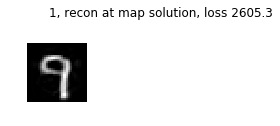

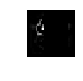

eigenvalues before and after inverse, approx hessian
[array([[9.9794918e-01, 9.9973339e-01, 9.9996156e-01, 9.9996579e-01,
        9.9999845e-01, 1.0000204e+00, 1.0000633e+00, 1.0008980e+00,
        1.0039040e+00, 9.0779641e+04]], dtype=float32), array([[1.10156868e-05, 9.99030417e-01, 9.99876190e-01, 9.99936051e-01,
        9.99992867e-01, 9.99997982e-01, 1.00002783e+00, 1.00007366e+00,
        1.00027724e+00, 1.00148708e+00]])]


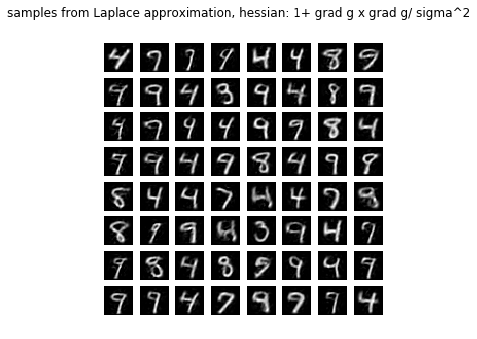

covariances
(1, 10, 10)


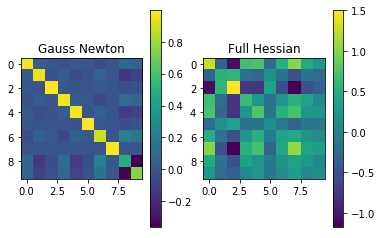

hessians
(1, 10, 10)


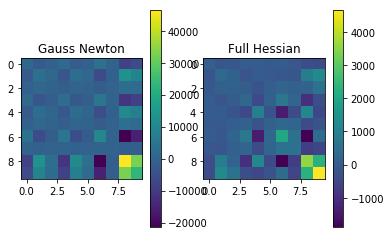

eigenvalues before and after inverse, full hessian
[array([[1.9530617e-01, 1.6788211e+00, 1.7604191e+00, 4.2724767e+00,
        6.6164513e+00, 2.8355684e+01, 6.1174606e+01, 6.5806677e+02,
        4.6542178e+03, 7.5048896e+03]], dtype=float32), array([[1.33246449e-04, 2.14858912e-04, 1.51960313e-03, 1.63466243e-02,
        3.52665075e-02, 1.51145021e-01, 2.34052133e-01, 5.67840208e-01,
        5.95665276e-01, 5.12904164e+00]])]
1


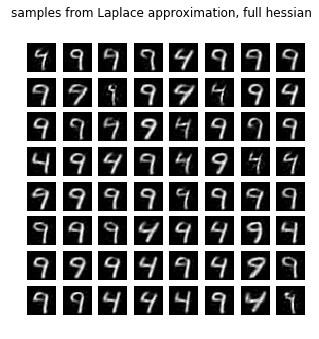

diagonal approx


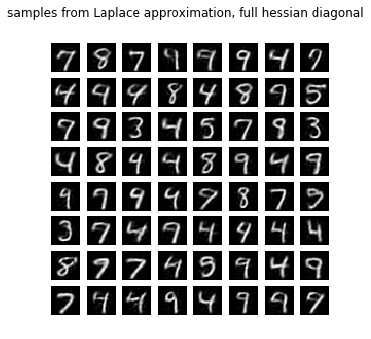

hessian successful 1


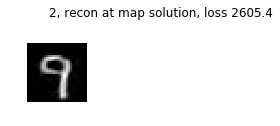

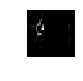

eigenvalues before and after inverse, approx hessian
[array([[9.9945557e-01, 9.9995083e-01, 9.9999720e-01, 9.9999756e-01,
        9.9999815e-01, 1.0000008e+00, 1.0000023e+00, 1.0000048e+00,
        1.0000657e+00, 1.6148045e+04]], dtype=float32), array([[6.19269999e-05, 9.99951568e-01, 9.99968033e-01, 9.99993686e-01,
        9.99997716e-01, 9.99999609e-01, 1.00000087e+00, 1.00000195e+00,
        1.00000508e+00, 1.00006140e+00]])]


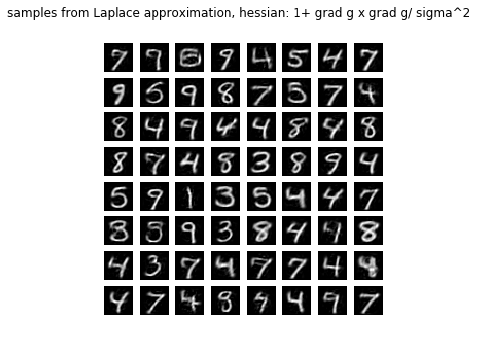

covariances
(1, 10, 10)


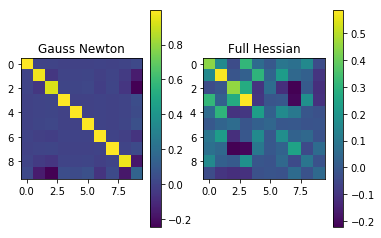

hessians
(1, 10, 10)


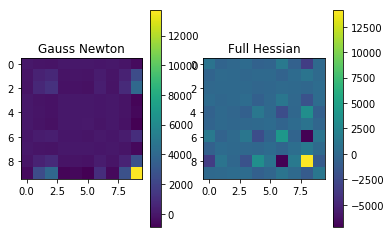

eigenvalues before and after inverse, full hessian
[array([[9.1312963e-01, 9.8916459e-01, 1.9259598e+00, 5.5705123e+00,
        1.7634096e+01, 3.1181124e+01, 5.6530968e+01, 7.3770740e+02,
        1.9746985e+03, 2.0162312e+04]], dtype=float32), array([[4.95974953e-05, 5.06406457e-04, 1.35555089e-03, 1.76893909e-02,
        3.20708136e-02, 5.67072628e-02, 1.79507907e-01, 5.19019138e-01,
        1.01080856e+00, 1.09493178e+00]])]
1


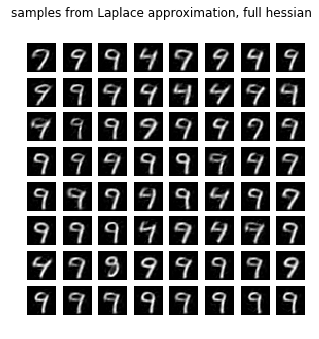

diagonal approx


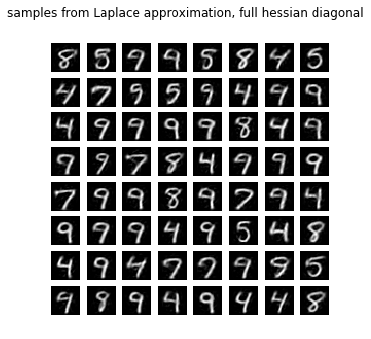

hessian successful 2


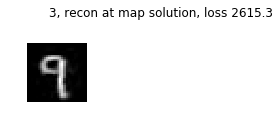

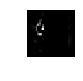

eigenvalues before and after inverse, approx hessian
[array([[9.8898441e-01, 9.9934828e-01, 9.9979115e-01, 9.9986637e-01,
        1.0000018e+00, 1.0000064e+00, 1.0002544e+00, 1.0009960e+00,
        1.0020539e+00, 1.4431245e+05]], dtype=float32), array([[6.92941003e-06, 9.99174156e-01, 9.99669269e-01, 9.99785383e-01,
        9.99882497e-01, 1.00000035e+00, 1.00001176e+00, 1.00026750e+00,
        1.00060714e+00, 1.00099803e+00]])]


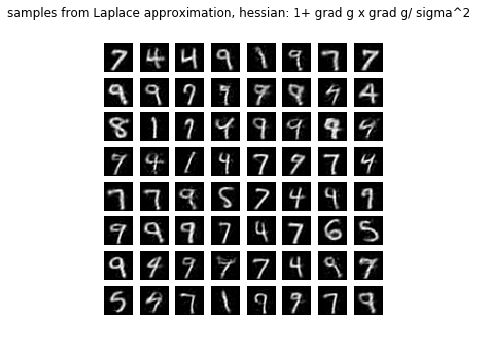

covariances
(1, 10, 10)


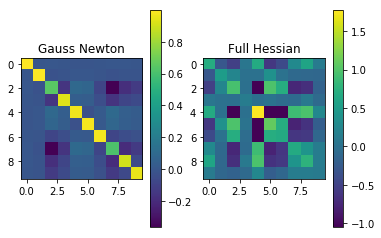

hessians
(1, 10, 10)


eigenvalues before and after inverse, full hessian
[array([[1.8119271e-01, 1.1602910e+00, 1.6910380e+00, 4.2650094e+00,
        1.0280976e+01, 1.1289983e+01, 9.7536537e+01, 1.0420771e+03,
        3.6798306e+03, 9.2137246e+03]], dtype=float32), array([[1.08533721e-04, 2.71751682e-04, 9.59621638e-04, 1.02526092e-02,
        8.85791690e-02, 9.72669166e-02, 2.34460318e-01, 5.91250502e-01,
        8.61813309e-01, 5.51872955e+00]])]
1


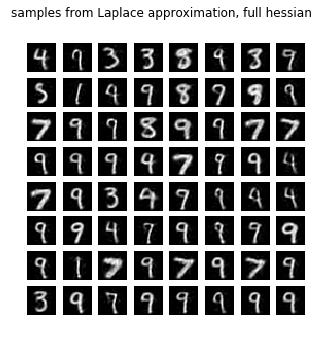

diagonal approx


hessian successful 3


eigenvalues before and after inverse, approx hessian
[array([[9.9939376e-01, 9.9956542e-01, 9.9993461e-01, 9.9997270e-01,
        9.9999791e-01, 1.0000267e+00, 1.0000529e+00, 1.0002267e+00,
        1.0055376e+00, 7.1445461e+04]], dtype=float32), array([[1.39966933e-05, 9.99126551e-01, 9.99841589e-01, 9.99898285e-01,
        9.99976679e-01, 9.99995783e-01, 1.00001974e+00, 1.00002201e+00,
        1.00009733e+00, 1.00049710e+00]])]


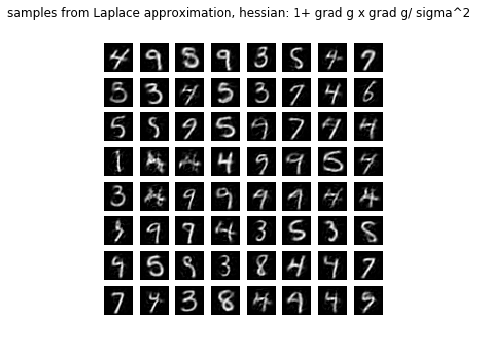

covariances
(1, 10, 10)


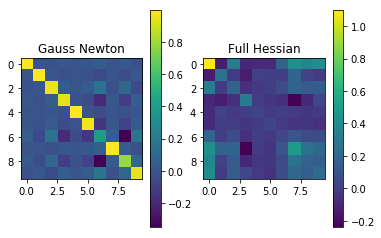

hessians
(1, 10, 10)


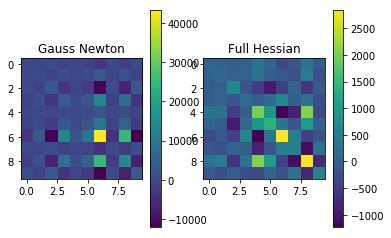

eigenvalues before and after inverse, full hessian
[array([[5.4337084e-01, 1.5272667e+00, 4.5831151e+00, 1.1405340e+01,
        2.2744076e+01, 3.0649704e+01, 1.5865103e+02, 1.4924584e+03,
        3.4251926e+03, 6.1499092e+03]], dtype=float32), array([[1.62604004e-04, 2.91954429e-04, 6.70035563e-04, 6.30314918e-03,
        3.26262376e-02, 4.39682855e-02, 8.76785859e-02, 2.18200790e-01,
        6.54763817e-01, 1.84014304e+00]])]
1


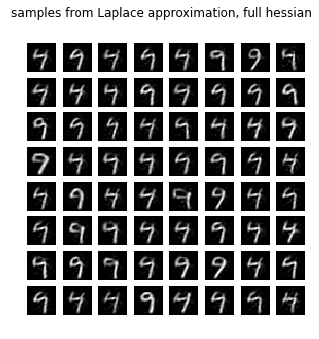

diagonal approx


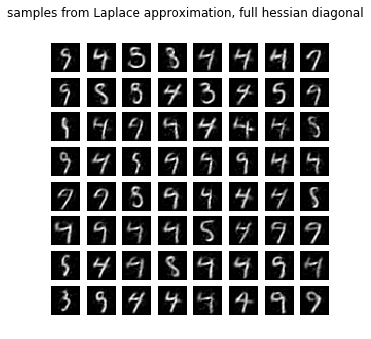

hessian successful 4


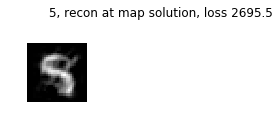

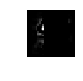

eigenvalues before and after inverse, approx hessian
[array([[9.4776279e-01, 9.9356604e-01, 9.9881941e-01, 9.9952257e-01,
        1.0001127e+00, 1.0001333e+00, 1.0006189e+00, 1.0021558e+00,
        1.0247240e+00, 7.3436425e+05]], dtype=float32), array([[1.36172209e-06, 9.89680196e-01, 9.92225740e-01, 9.99361619e-01,
        9.99647835e-01, 9.99964189e-01, 1.00031266e+00, 1.00106584e+00,
        1.00135078e+00, 1.01220365e+00]])]


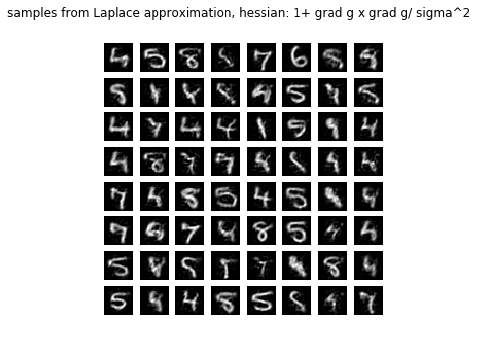

covariances
(1, 10, 10)


hessians
(1, 10, 10)


eigenvalues before and after inverse, full hessian
[array([[7.4581712e-01, 1.2173792e+00, 1.3271143e+00, 2.6377139e+00,
        2.9209867e+01, 8.3057053e+01, 1.4575565e+02, 6.5675037e+02,
        5.7821328e+03, 3.1824434e+04]], dtype=float32), array([[3.14223969e-05, 1.72946635e-04, 1.52264903e-03, 6.86077393e-03,
        1.20400531e-02, 3.42362598e-02, 3.79164273e-01, 7.53605254e-01,
        8.21592096e-01, 1.34080537e+00]])]
1


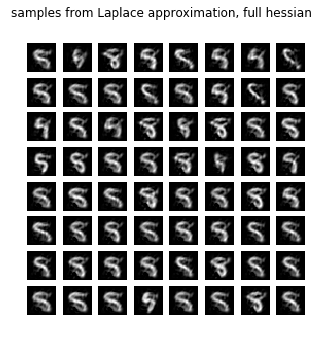

diagonal approx


hessian successful 5


In [153]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 

order      = np.argsort(l_minima_pos_def)
results    = np.concatenate((np.expand_dims(map_minima[0],0),map_minima_pos_def[order]), axis=0)
l_results  = np.concatenate((np.expand_dims(l_minima[0],0),l_minima_pos_def[order]), axis=0)
# go through minima
for ii,ini_ in enumerate(results):
  
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_results[ii])
  else:
    suptitle('%d, recon at map solution, loss %.1f'%(ii,l_results[ii]))
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
      
      subplot(4,4,i+1)
      imshow(np.reshape((mean_at_map[i,:,0]-data[0,:,0])*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian diagonal')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    print('hessian successful',ii)
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


In [154]:
# check if minima are distinct
order = np.argsort(l_minima_pos_def)
map_minima_pos_def = np.asarray(map_minima_pos_def[order])
l_minima_pos_def   = np.asarray(l_minima_pos_def[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_minima), vmax=max(l_minima))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(results)):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d_nolbfgs.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**explore posterior around minima**

In [155]:
order     = np.argsort(l_minima_pos_def)[0]

# testing Hessian
for ii,ini_ in enumerate([map_minima_pos_def[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
    VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

    z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
    VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

    z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.001*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
      

    
    
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+B*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    #plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    #plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+GN*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(-ll0,-ll0+3)
#     if nn in [0,1]:
    plt.xlim(ini_[0][:,nn]-0.2, ini_[0][:,nn]+0.2)
#     elif nn in [2,3,4,5,6,9]:
#       plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
#     elif nn in [7,8]:
#       plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d_noVI_start0_rescaled_nolbfgs.png'%(minx,maxx),bbox_inches='tight')


**Build Gaussian Mixture Model**

In [159]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]
num_comp= 2# len(l_minima_pos_def)[]
offset  =2200 #for numerical stability
order   = np.argsort(l_minima_pos_def)
mus     = map_minima_pos_def[order]

# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,MAP_ini:mus[ii][0],true_hess:True})]
  

  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logdet_,logprob,0.5*logdet_+logprob)
  w_tilde+=[np.exp(0.5*logdet_+logprob+offset)]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_d,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })



[-34.1075003] [-2605.2534] [-2622.30716812]
[-36.71964851] [-2605.415] [-2623.77486332]
[-34.03897428] [-2615.262] [-2632.28145003]
[[3.92940883e-184]
 [9.05555957e-185]
 [1.83042367e-188]]
[8.12676048e-01 1.87286095e-01 3.78566226e-05]


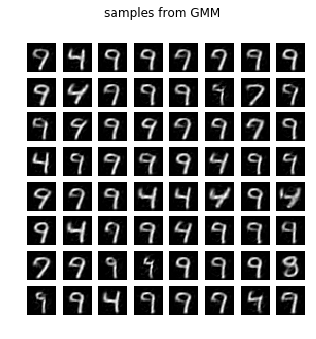

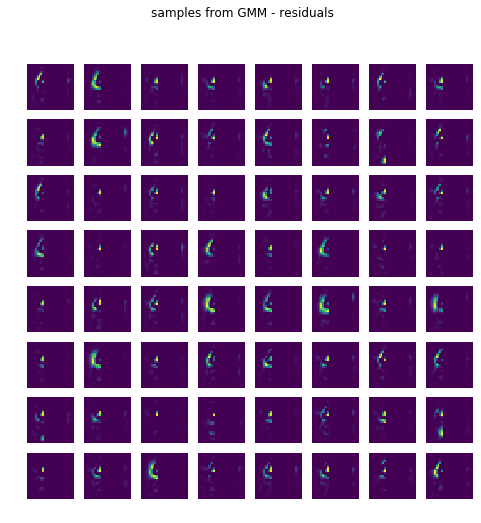

In [167]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [165]:
for ii in range(50):
  _, ll, mm, ww = sess.run([opt_op_el2o,el2o, mu_gmm,w_gmm],feed_dict={x_corr: data, sigma_corr:sigma_new, lr:1e-3})
  print(ll)#, mm, ww)

181316510.0
13159574.0
56590772.0
50715184.0
60348932.0
89744790.0
23355144.0
566977400.0
21275840.0
66136176.0
4412363000.0
11586700.0
9858450000.0
11352841.0
7931620.5
89161170.0
15000216.0
9402536.0
21928075000.0
131642856.0
111709464.0
39713580.0
31276200.0
16067072.0
10150590.0
9821816000.0
22571846.0
27461508.0
92896340.0
11570105.0
13727484.0
8139968.0
9509514.0
12235288.0
128535850.0
241173330.0
1324996900.0
12432547.0
103766780.0
8770500.0
11637452.0
327687840.0
10982705.0
10645156.0
19757646000.0
522569120.0
48779016.0
32914252.0
1089924200.0
590818400.0
